## This page is under development...

I'm using yfinance package to download the stock data from yahoo finance. Then I will try predicting the prices for each stock. My goal is to make a prediction on the expected value and variance of the price based on the previous values. Then I'll try to compute the experimental covarience between different stocks and input them to an optimization problem designed to reduce the mixed variance while maximizing the expected output. This is based on the mean-volatility predicate in financial analysis.  
My initial intention was to use the rather new *tensorflow probability* capability to estimate the mean a variance for each output point. After some trials and failings, I have decided to use a simpler approach:
 - Use a small Nueral Net to compute a predicted value for the next days opening price for each stock.
 - Assume that my predictor assumes a normal distribution around the observed values (I should check this!). Therefore I can use the unbiased estimator of SD to find the expected variance around my predicted price.
 - Compute the correlations between different stocks experimentally (i.e. pairwise correlation between data columns)
 - perform the optimization as before.

In [64]:
import importlib
import single_stock_predictor
importlib.reload(single_stock_predictor)
import pickle
import yfinance as yf
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
#import mdn
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import h5py

%matplotlib notebook

If running for first time, you need to downloaded the stock symbols or "tickers". This is in done by setting parameter  "get_tickers".<br> Currently I'm downloading the daily data for 9years. If you already have downloaded some part of the data you can download the rest and append them to each other. Later I hope to automatize this section, since my goal is to run this script once weekly or so.

In [2]:
get_tickers = False 
read_tickers = False
get_histories = False

In [3]:
if get_tickers:
    !curl -o /Users/abnousa/software/smartop/nasdaqtraded_companylist.txt ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt
    symbols = pd.read_csv("/Users/abnousa/software/smartop/nasdaqtraded_companylist.txt", sep = "|")
    symbols = symbols.iloc[0:(symbols.shape[0] - 1),:] #last row is time
    tickers = {}
    failed = []
    for i in symbols.index:
        sym = symbols.iloc[i]['Symbol']
        ticker = yf.Ticker(sym)
        try:
            check = ticker.calendar
        except Exception as e:
            print(' '.join(["disregarding", sym, type(e).__name__]))
            failed.append(sym)
            continue
        print(' '.join([sym, 'added']))
        name = symbols.iloc[i]['Security Name']
        tickers[sym] = {'name': name, 'ticker': ticker}
    sym_data = {'tickers':tickers, 'failed':failed}
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)

In [4]:
if read_tickers:
    with open('sym_data.pkl', 'rb') as symfile:
        sym_data = pickle.load(symfile)
        tickers, failed = sym_data['tickers'], sym_data['failed']

In [5]:
if get_histories:
    msft = yf.Ticker("MSFT")
    temp_hist = msft.history(period="9y", interval="1d")
    d = pd.DataFrame(data = 0, columns = list(tickers.keys()), index = temp_hist.index)
    for i in d.columns:
        print(i)
        hist = tickers[i]['ticker'].history(start = list(temp_hist.index)[0], end = list(temp_hist.index)[-1], interval = "1d")['Open']
        d[i] = hist
    with open("daily_history_9y.pkl", 'wb') as histfile:
        pickle.dump(d, histfile)

In [6]:
with open("daily_history_9y.pkl", 'rb') as infile:
    d = pickle.load(infile)

(array([4166.,   28.,   26.,   48.,   21.,   23.,   20.,   10.,   23.,
          24.,   22.,    8.,   56.,   17.,   46.,   21.,   14.,   23.,
          17.,   24.,   34.,   11.,   16.,   27.,   21.,   30.,   29.,
          31.,   28.,   23.,   38.,   60.,   27.,   23.,   46.,   28.,
          41.,   41.,   53.,   40.,   24.,   44.,   44.,   34.,   31.,
          34.,   32.,   25.,   35.,   36.,   58.,   28.,   32.,   36.,
          38.,   29.,   16.,   20.,   25.,   36.,   39.,   28.,   25.,
          46.,   39.,   26.,   34.,   35.,   21.,   27.,   38.,   37.,
          62.,   28.,   30.,   57.,   89.,   50.,   45.,   40.,   48.,
          37.,   45.,   46.,   56.,   45.,   71.,   46.,   35.,   33.,
          25.,   66.,   59.,   44.,   38.,   38.,   20.,   57.,   47.,
          38.]),
 array([   0.  ,   22.64,   45.28,   67.92,   90.56,  113.2 ,  135.84,
         158.48,  181.12,  203.76,  226.4 ,  249.04,  271.68,  294.32,
         316.96,  339.6 ,  362.24,  384.88,  407.52,  430.16

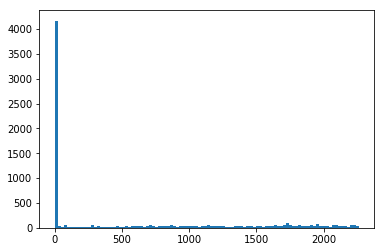

In [7]:
plt.hist(d.isna().sum(), bins = 100)

In [8]:
d = d.iloc[:, list(np.where(d.isna().sum() < 20)[0])]
d = d.fillna(method = "bfill")
d.shape

(2264, 4165)

In [29]:
stock_name = "MSFT"
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 20
training_points = 1500
sd_estimate_required = True
model_outdir = "models"
training_verbosity = 1
pred, train_sd, train_forecasts, valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, sd_estimate_required = sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
46/46 [==============================] - 5s 109ms/step - loss: 352.8819 - val_loss: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 1s 25ms/step - loss: 1.1388 - val_loss: 2.2652
Epoch 3/20
46/46 [==============================] - 1s 25ms/step - loss: 0.4294 - val_loss: 2.2327
Epoch 4/20
46/46 [==============================] - 1s 24ms/step - loss: 0.3935 - val_loss: 2.2279
Epoch 5/20
46/46 [==============================] - 1s 24ms/step - loss: 0.4128 - val_loss: 2.2354
Epoch 6/20
4

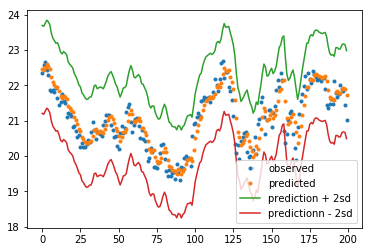

In [30]:
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, train_sd, window_size, limit_begin = 0, limit_end = 200)

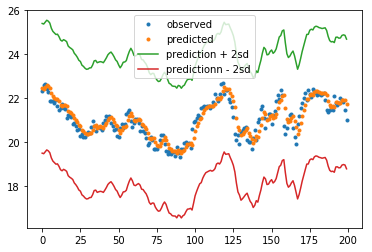

In [31]:
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, valid_sd, window_size, limit_begin = 0, limit_end = 200)

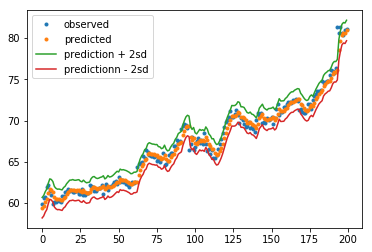

In [32]:
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, train_sd, window_size, limit_begin = 0, limit_end = 200)

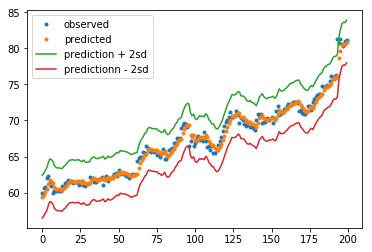

In [33]:
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, valid_sd, window_size, limit_begin = 0, limit_end = 200)

In [34]:
print(train_sd, valid_sd)

0.6212235072267154 1.4787471117113362


okay, so far we have showed that for the specified stock (here, MSFT aka microsoft) our model generates rather dependable predictions of price and our estimated standard deviation seems to be fitting at least visually. Of course, one can argue that we have picked an easy ticker, you'd expect microsoft to have a stable price. Well, I can't argue against that. But now, I'm going to randomly pick 10 tickers and perform the same operation on each of them. Before that I
m going to use the *cov()* function from pandas to compute pairwise correlation between the selected tickers.

In [35]:
import random
ticker_set = random.sample(list(d.columns), 10)
ticker_set

['FLT', 'WAFD', 'SORL', 'NAVB', 'TRN', 'DBE', 'IYW', 'AMOV', 'OLP', 'RIGL']

In [49]:
d_select = d[ticker_set]
print(d_select.shape)
corels = d_select.corr()

(2264, 10)


(<matplotlib.image.AxesImage at 0x1bde6b7b8>,
 <matplotlib.colorbar.Colorbar at 0x1c7545dd8>)

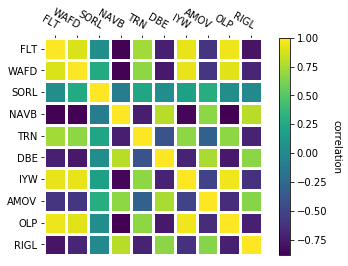

In [50]:
corels_matrix = np.array(corels)
heatmap(corels_matrix, corels.columns.values, corels.columns.values, cbarlabel = "correlation")

In [51]:
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 20
training_points = 1500
sd_estimate_required = True
model_outdir = "models"
training_verbosity = 0

In [52]:
prediction_dict = {}
for stock_name in ticker_set:
    print(" ".join(["processing", stock_name]))
    pred, train_sd, train_forecasts, valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, sd_estimate_required = sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity)
    prediction_dict[stock_name] = {'expected_tomorrow': pred,
                                   'train_sd': train_sd,
                                   'train_forecasts': train_forecasts,
                                   'valid_sd': valid_sd,
                                   'valid_forecasts': valid_forecasts}

processing FLT
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
46/46 [==============================] - 3s 71ms/step - loss: 5830.9199 - val_loss: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 1s 25ms/step - loss: 12.4374 - val_loss: 14.9658
Epoch 3/20
46/46 [==============================] - 1s 25ms/step - loss: 5.0149 - val_loss: 14.6789
Epoch 4/20
46/46 [==============================] - 1s 25ms/step - loss: 4.6104 - val_loss: 24.4665
Epoch 5/20
46/46 [==============================] - 1s 27ms/step - loss: 4.4526 - val_loss: 

46/46 [==============================] - 3s 62ms/step - loss: 896.2306 - val_loss: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 1s 26ms/step - loss: 11.9938 - val_loss: 0.6883
Epoch 3/20
46/46 [==============================] - 1s 28ms/step - loss: 6.8575 - val_loss: 0.5632
Epoch 4/20
46/46 [==============================] - 1s 29ms/step - loss: 6.6393 - val_loss: 0.4541
Epoch 5/20
46/46 [==============================] - 1s 29ms/step - loss: 6.8205 - val_loss: 0.3711
Epoch 6/20
46/46 [==============================] - 1s 30ms/step - loss: 6.5930 - val_loss: 0.3405
Epoch 7/20
46/46 [==============================] - 1s 29ms/step - loss: 6.6179 - val_loss: 0.3331
Epoch 8/20
46/46 [==============================] - 1s 27ms/step - loss: 6.4742 - val_loss: 0.3405
Epoch 9/20
46/46 [==============================] - 1s 26ms/step - loss: 5.8777 - val_loss: 0.2692
Epoch 10/20
46/46 [==============================] - 1s 28ms/step - loss: 5.6869 - val_loss: 0.3469
Epoch 11/20
4

Epoch 4/20
46/46 [==============================] - 1s 27ms/step - loss: 1.6356 - val_loss: 8.0128
Epoch 5/20
46/46 [==============================] - 1s 27ms/step - loss: 1.7585 - val_loss: 7.7706
Epoch 6/20
46/46 [==============================] - 1s 27ms/step - loss: 1.7601 - val_loss: 8.6382
Epoch 7/20
46/46 [==============================] - 1s 26ms/step - loss: 1.6095 - val_loss: 7.7575
Epoch 8/20
46/46 [==============================] - 1s 26ms/step - loss: 1.5793 - val_loss: 9.5000
Epoch 9/20
46/46 [==============================] - 1s 26ms/step - loss: 1.6429 - val_loss: 8.8689
Epoch 10/20
46/46 [==============================] - 1s 26ms/step - loss: 1.7330 - val_loss: 7.7064
Epoch 11/20
46/46 [==============================] - 1s 25ms/step - loss: 1.7721 - val_loss: 7.7110
Epoch 12/20
46/46 [==============================] - 1s 25ms/step - loss: 1.6333 - val_loss: 8.5117
Epoch 13/20
46/46 [==============================] - 1s 26ms/step - loss: 1.6587 - val_loss: 7.3107
Epoch 

Epoch 7/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0677 - val_loss: 0.0266
Epoch 8/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0702 - val_loss: 0.0244
Epoch 9/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0618 - val_loss: 0.0248
Epoch 10/20
46/46 [==============================] - 1s 29ms/step - loss: 0.0620 - val_loss: 0.0240
Epoch 11/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0668 - val_loss: 0.0247
Epoch 12/20
46/46 [==============================] - 1s 26ms/step - loss: 0.0608 - val_loss: 0.0231
Epoch 13/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0580 - val_loss: 0.0222
Epoch 14/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0622 - val_loss: 0.0235
Epoch 15/20
46/46 [==============================] - 1s 28ms/step - loss: 0.0684 - val_loss: 0.0218
Epoch 16/20
46/46 [==============================] - 1s 29ms/step - loss: 0.0681 - val_loss: 0.0212
Epo

It looks like for a few of the stocks, validation error was smaller than the training error. I'm curious why.

So here are the plots from validation data:

<IPython.core.display.Javascript object>


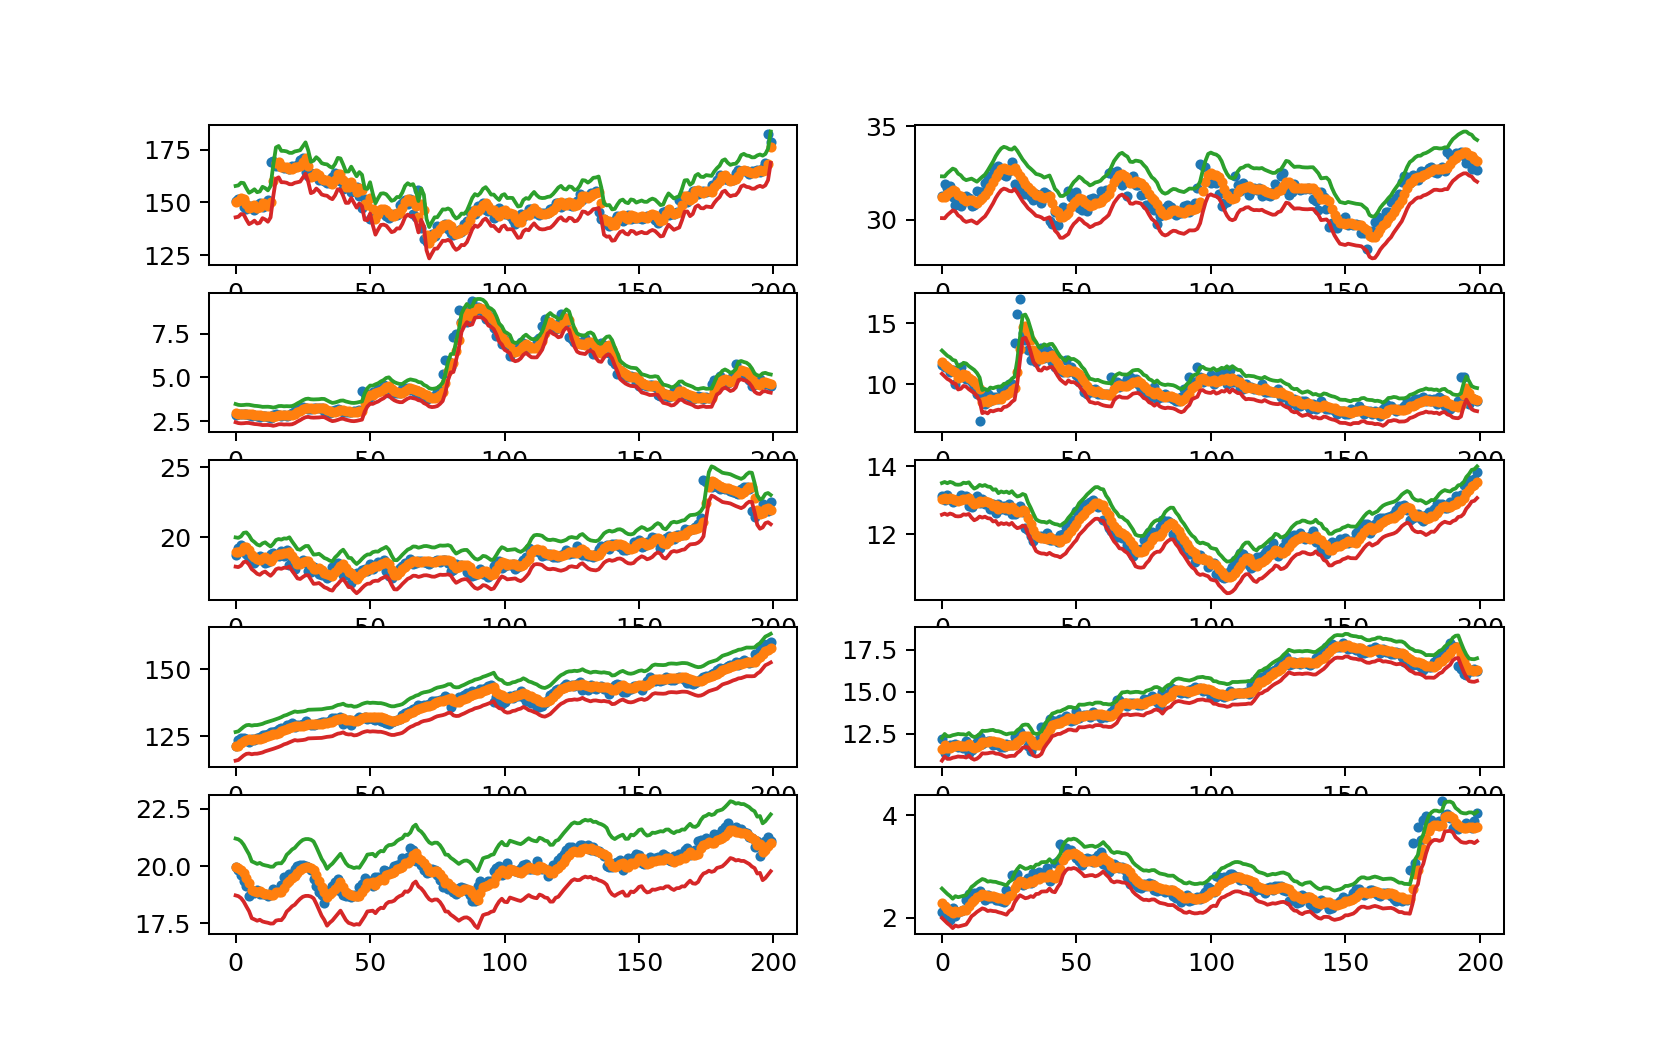

In [67]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name][training_points:], prediction_dict[stock_name]['valid_forecasts'], prediction_dict[stock_name]['valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False)
    
            

and here are plots for training data:

<IPython.core.display.Javascript object>


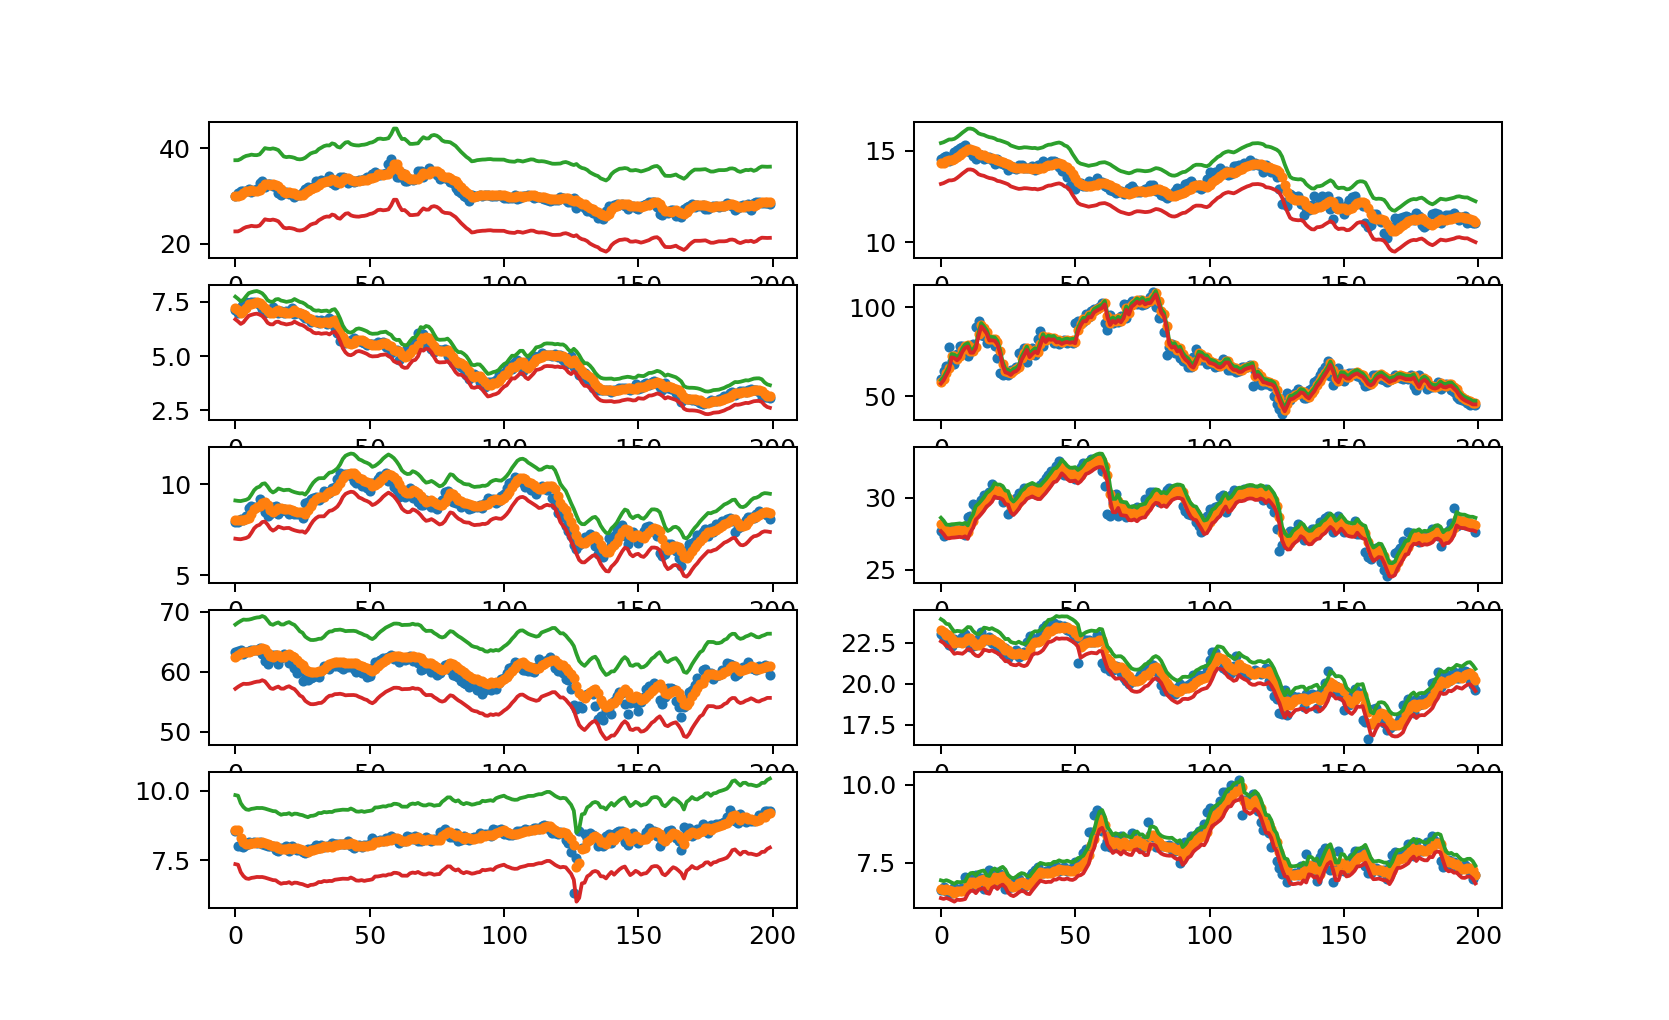

In [68]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name], prediction_dict[stock_name]['train_forecasts'], prediction_dict[stock_name]['valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False)
    

In [70]:
d_select.head()

,FLT,WAFD,SORL,NAVB,TRN,DBE,IYW,AMOV,OLP,RIGL
Date,,,,,,,,,,
2010-12-23,28.91,13.78,8.61,39.0,7.10,26.03,59.08,22.69,9.19,7.78
2010-12-27,30.83,13.71,8.53,38.8,7.05,26.07,58.94,22.56,9.19,7.78
2010-12-28,30.83,13.80,8.75,39.0,7.16,26.20,59.32,22.65,9.10,7.79
2010-12-29,31.00,13.76,8.48,39.4,7.22,26.19,59.28,22.88,9.02,7.69
2010-12-30,30.71,13.81,8.42,39.6,7.22,26.10,59.19,22.82,8.87,7.70


In [43]:
#funnction copied from matplotlib gallery
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [44]:
covars

,FLT,WAFD,SORL,NAVB,TRN,DBE,IYW,AMOV,OLP,RIGL
FLT,5237.231496,494.029412,4.986575,-1550.674010,317.817562,-382.413270,3158.564243,-133.187457,387.881112,-136.307916
WAFD,494.029412,58.531584,3.059908,-163.970099,30.957062,-42.196770,334.963628,-13.860299,39.578118,-12.494651
SORL,4.986575,3.059908,2.193043,-3.464408,1.999206,0.437986,13.095369,1.299453,0.370297,0.019722
NAVB,-1550.674010,-163.970099,-3.464408,597.427219,-105.464341,141.927949,-982.136218,50.864758,-122.065494,46.511435
TRN,317.817562,30.957062,1.999206,-105.464341,35.389796,-17.533945,188.736895,-5.489289,22.854104,-9.956857
DBE,-382.413270,-42.196770,0.437986,141.927949,-17.533945,53.458810,-238.582697,17.017998,-31.153135,11.814976
IYW,3158.564243,334.963628,13.095369,-982.136218,188.736895,-238.582697,2180.941707,-72.425651,251.864558,-69.151132
AMOV,-133.187457,-13.860299,1.299453,50.864758,-5.489289,17.017998,-72.425651,9.422551,-11.128204,4.821665
OLP,387.881112,39.578118,0.370297,-122.065494,22.854104,-31.153135,251.864558,-11.128204,31.734795,-9.719825
RIGL,-136.307916,-12.494651,0.019722,46.511435,-9.956857,11.814976,-69.151132,4.821665,-9.719825,5.718475


Some of the stock data have a lot of missing points over the past 9 years. This might be because they were founded later or had their IPO sometime during this time-period. Below I take a look at the number of stocks with various numbers of missing points and filter the data to the ones with less than 20 NA's. I will impute the missing points by "backward filling".

Alright, now we have the data and for each stock we can take a look at their trend. Change the *ticker_name* below and have a look at the plot. I'm plotting the Microsoft stock prices from some day in December 2012 up to December 2019.

In [ ]:
ticker_name = "MSFT"
import matplotlib.pyplot as plt
plt.plot(d[ticker_name])

In [ ]:
# this function is copied exactly from the deeplearning.ai course on time-series analysis on coursera!
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[0].reshape((len(window[0], 1))), window[1]))
    else:
        dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
stock_name = "MSFT"
weekly = False

In [ ]:
#d = d.iloc[:, :1]#:int(d.shape[1]/2)]
d = d.loc[:,[stock_name]]
d.describe()

In [ ]:
if weekly:
    d.reset_index(drop = False, inplace = True)
    d['weekday'] = d['Date'].dt.day_name()
    d = d[d['weekday'] == "Friday"]
    d.drop(['Date', 'weekday'], axis = 1, inplace = True)
    print(d.shape)
    print(d.head())
    d.reset_index(drop = True, inplace = True)

In [ ]:
d.head()

In [ ]:
p = d.reset_index(drop = True)
plt.plot(p[stock_name])

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer = 100000
training_points = 350 if weekly else 1500

In [ ]:
#d = d / train_d.max(axis = 0)
train_d = d.iloc[:training_points, :]
valid_d = d.iloc[training_points:, :]
train_df = windowed_dataset(train_d.to_numpy().reshape((len(train_d,))), window_size, batch_size, shuffle_buffer)
normalization_factors = train_d.max()
valid_df = windowed_dataset(valid_d.to_numpy().reshape((len(valid_d,))), window_size, batch_size, shuffle_buffer, shuffle = False)

In [ ]:
train_df
valid_df

In [ ]:
#td = windowed_dataset(np.array(train_d['MSFT']), window_size, batch_size, shuffle_buffer)
#td

In [ ]:
#train_y = train_d[30:]
#train_y.shape
train_d[stock_name].shape
train_d.shape

In [ ]:
train_d.describe()
valid_d.describe()

In [ ]:
def layer_normalize(x, factors = None, denorm = False, input_mean = None, input_std = None):
    if factors is None:
        factors = tf.reduce_max(x, axis = 0, keepdims = False)
        #tf.print(factors)
        tf.print("pre mod shape of x")
        tf.print(tf.shape(x))
        tf.print("shape of factors")
        tf.print(tf.shape(factors))
    input_mean = tf.math.reduce_mean(x, axis = 0)
    input_std = tf.keras.backend.std(x)
    if denorm:
        #x += 1
        factors = 1. / factors
    x /= factors
    '''
    if not denorm:
        if len(x.get_shape()) == 3:
            #tf.print('mean', input_mean)
            #tf.print('std')
            #tf.print('std', input_std)
            #tf.print('oldx')
            #tf.print('shape',x.get_shape())
            #tf.print(x)
            x = (x - input_mean)/input_std
    else:
        #tf.print('mean')       
        #tf.print(len(x.get_shape()))
        x = x * input_std + input_mean
    '''
    #x = (x - tf.keras.backend.mean(x)) / tf.keras.backend.std(x)
    #tf.print("post mod shape of x")
    #tf.print(tf.shape(x))
    return x

In [ ]:
distributional = False
tf.compat.v1.reset_default_graph()
#output_size = train_d.shape[1]
tfd = tfp.distributions
output_dense_size = 2 if distributional else 1

def activations(l, input_mean = None, input_std = None, window_size = None):
    l_0 = (tf.keras.activations.linear(l[...,0])) * input_mean #* input_std) + input_mean #* normalization_factors
    #l_1 = std_multiplier + 
    l_1 = ((tf.keras.activations.linear(tf.abs(l[...,1])))) + 1e-6 # * input_std + input_mean) / window_size) / 0.5
    #tf.print(l_1)
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

def simple_activations(l):
    l_0 = tf.keras.activations.linear(l[...,0])
    l_1 = tf.keras.activations.elu(l[...,1])
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

initializers = "glorot_normal"
activation_name = 'relu'
model = tf.keras.models.Sequential([
  #tf.keras.layers.LayerNormalization(axis = 0),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : False}, input_shape = (window_size,)),
  #tf.keras.layers.GRU(32, return_sequences = True, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)), 
  #tf.keras.layers.Conv1D(128, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(pool_size = 3, padding = 'valid'),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.1),
  #tf.keras.layers.GRU(8, return_sequences=True, kernel_initializer = initializers),
  tf.keras.layers.GRU(64, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)),
  #tf.keras.layers.LSTM(32, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.Dense(output_dense_size, activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)), kernel_initializer = "he_normal"),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}),
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=tf.abs(t[..., 0]), scale=0.01*(tf.abs(t[..., 1]))))#-t[...,0]))))#t[...,1])) 
  #                         #scale=(tf.keras.backend.std[...,1])))
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,0], scale = t[...,0] + tf.keras.backend.std(t[:,1])))
  #                         #scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
  #tfp.layers.IndependentNormal(output_size)
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

if distributional:
    model.add(tf.keras.layers.Dense(
        output_dense_size, activation = 'linear',
        #activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)),
        #activation = tf.keras.layers.Activation(lambda x: simple_activations(x)),
        kernel_initializer = "he_uniform"))
    model.add(tfp.layers.DistributionLambda(lambda t: 
                                            tfd.Normal(
                                                loc=tf.abs(t[..., 0]), 
                                                scale= 1e-6 + tf.abs(t[..., 1]) #* normalization_factors
                                            )))
else: 
    #model.add(tf.keras.layers.Dense(128, activation = 'linear'))
    model.add(tf.keras.layers.Dense(1, activation = 'linear', kernel_initializer = initializers))
    #model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : True}))
#model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}))
    
negloglik = lambda y, p_y: -p_y.log_prob(y)
#negcheck = lambda y, yh: tf.math.abs(y - yh[:,0])
#optimizer = tf.keras.optimizers.Adam()#.minimize(cost)
#model.compile(#loss=tf.keras.losses.Huber(),
#              loss=negloglik,
#              #loss = 'mse',
#              #loss = cost,
#              optimizer=optimizer,
#              #optimizer = 'Adam',
#              metrics = ['mae']
#             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
#history = model.fit(train_df, epochs=10, validation_data = valid_df)

loss_function = negloglik if distributional else 'mse' #tf.keras.losses.Huber()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
model.fit(train_df, epochs=20, verbose=True, validation_data = valid_df)

In [ ]:
xh = model.predict(train_df)
forecasts_x = []
sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(train_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(train_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts_x.append(prediction)
    sds.append(prediction - vs[time+window_size])
sd_estimate = np.sqrt(np.sum(np.array(sds)**2) / (training_points - window_size - 1))
forecasts_x = np.array(forecasts_x)[:,0].reshape((training_points - window_size))

In [ ]:
limit_begin = 150
limit_end = 300
plt.plot(np.array(train_d[(window_size + limit_begin): (window_size + limit_end)]), '.')
plt.plot(forecasts_x[limit_begin:limit_end], '.')
plt.plot(forecasts_x[limit_begin:limit_end] + 2*sd_estimate, '-')
plt.plot(forecasts_x[limit_begin:limit_end] - 2*sd_estimate, '-')

In [ ]:
tomorrows_prediction = model.predict(np.array(d[stock_name])[-window_size:].reshape(1, window_size, 1))[0, 0]
tomorrows_prediction

In [ ]:
training_points - window_size

In [ ]:
print(xh[:10])
print(train_d[window_size:window_size + 10])
print((xh - np.array(train_d[window_size:]))[:10])

In [ ]:
forecasts = []
#sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(valid_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(valid_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts.append(prediction)
    sds.append(vs[time+window_size] - prediction)
    #forecasts.append(model(vs[time:time+window_size].reshape((1, window_size, 1))))
#print(vs[:window_size])
#print(forecasts)

In [ ]:
print(len(forecasts))
forecasts[1]
if distributional:
    ymeans = np.array([i.mean() for i in forecasts])
    ystdv = np.array([i.stddev() for i in forecasts])
else:
    forecasts = np.array(forecasts[:,0,0])
    sds = np.array(sds)[:,0,0]
forecasts
sd_estimate = np.sqrt(np.sum(sds ** 2)/(sds.shape[0]-1))
sd_estimate

In [ ]:
sds.shape[0]

In [ ]:
forecasts[0].shape
results = np.array(forecasts)[:, 0]
np.max(results)

In [ ]:
plt.plot(np.array(valid_d)[window_size + 100: window_size + 150], '.', label = 'obs')
plt.plot(forecasts[100:150], '.', label = 'pred')
plt.plot(forecasts[100:150] + sd_estimate, '-')
plt.plot(forecasts[100:150] - sd_estimate, '-')
plt.legend()

## draftpad: (nothing interesting below)

In [ ]:
train_df

In [ ]:
x = np.zeros(shape = (batch_size, window_size))
y = np.zeros(shape = (batch_size, 1))
for i, j in valid_df:
    x = i
    y = j
    break

In [ ]:
print(x.shape, y.shape, distributional)

In [ ]:
if (distributional):
    ys = model(x)
    yhat = ys.mean()
    ydev = ys.stddev()
else:
    #ys = pd.DataFrame(model.predict(x))
    ys = model.predict(x)

In [ ]:
ys.shape

In [ ]:
plt.plot(y, '.', label = 'obs')
if distributional:
    plt.plot(yhat, 'r.', label = 'pred')
    plt.plot(yhat + 2*ydev, '-')
    plt.plot(yhat - 2*ydev, '-')
else:
    plt.plot(ys[:50, 0], '.', label = 'pred')
plt.legend()

In [ ]:
ys.shape

In [ ]:
ts = vs[:30].reshape((1, 30))
ts.shape
model.predict(ts)

In [ ]:
vs[time:time+window_size].reshape((window_size))

In [ ]:
plt.plot(y, 'b.')
plt.plot(model(x)[:,0], 'r.')
plt.plot(model(x)[:,0] + model(x)[:,1], '-')

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
yhat = model.predict(valid_df)

In [ ]:
mean = yhat.mean()
stddev = yhat.std()
mean_plus_2_stddev = mean - 2. * stddev
mean_minus_2_stddev = mean + 2. * stddev
#plt.plot(mean)#, 'o')
plt.plot(yhat, '.')
plt.plot(vd*normalization_factors + mean_plus_2_stddev, '-')

In [ ]:
vd = valid_d.reset_index(drop = True)
normalization_factors

In [ ]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

Since I'm trying to output mean and variance for each stock, I will need two units in my output layer and each will most likely require a different activation function. This can be done [at least more neatly] in funnctional API of keras.

In [ ]:
output_size = train_d.shape[1]
variables = train_d.shape[1]
#output_size = 1
print(output_size)
inputs = tf.keras.Input(shape=(None, variables))
normalization_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False})(inputs)
output_1 = tf.keras.layers.LSTM(128, return_sequences=True)(normalization_layer)
output_2 = tf.keras.layers.LSTM(256, return_sequences=True)(output_1)
output_3 = tf.keras.layers.LSTM(256, return_sequences=True)(output_2)
output_4 = tf.keras.layers.LSTM(128, return_sequences=False)(output_3)
#predictions = tf.keras.layers.Dense(1, activation='elu')(output_4)

#sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
#relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
#out = tf.concat([sigmoid_out, relu_out], axis=1)

#denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(predictions)

mu = tf.keras.layers.Dense(units=1, activation = 'elu')(output_4)
sigma = tf.keras.layers.Dense(units=1,activation=lambda x: tf.nn.elu(x) + 1)(output_4)

mu_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(mu)
sigma_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(sigma)

out = tf.concat([sigma_denorm, mu_denorm], axis=1)

model = tf.keras.Model(inputs=inputs, outputs=out)

'''
sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
out = tf.concat([sigmoid_out, relu_out], axis=1)
inner_layers.add(out)

denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})

inner_layers.add(denorm_layer)
model = inner_layers

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
'''
cost = mdn_cost(mu_denorm, sigma_denorm, y)
optimizer = tf.keras.optimizers.Adam().minimize(cost)
model.compile(#loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              loss = cost,
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
output_size = train_d.shape[1]
#output_size = 1
print(output_size)
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), #if the input is one stock
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  #tf.keras.layers.Conv1D(128, kernel_size = 3, input_shape = (batch_size, window_size, None)),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1, activation = 'relu'),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.GRU(512, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256),
  #tf.keras.layers.SimpleRNN(128, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, activation = 'tanh', return_sequences=True),
  #tf.keras.layers.LSTM(128),
  #tf.keras.layers.SimpleRNN(64, return_sequences = True),
  #tf.keras.layers.SimpleRNN(128, return_sequences = True),
  #tf.keras.layers.SimpleRNN(256),
  tf.keras.layers.Dense(output_size, activation = 'elu'),
  #tf.keras.layers.Lambda(lambda x: x + 1),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
d.to_numpy()[50:55, :8]
train_d.describe()

In [ ]:
#p = model.predict(np.array(d['MSFT']).reshape((len(d['MSFT']), 1)))
p = model.predict(train_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
p = pd.DataFrame(p)
p2 = p #* d.max(axis = 0).reset_index(drop = True)
p2.describe()

In [ ]:
### MDN MODEL

N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(1, activation = 'elu'),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])

model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=tf.keras.optimizers.Adam())
#model(train_df)
#model.summary()
history = model.fit(train_df, epochs=10)
p = model.predict(train_df)
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, p, OUTPUT_DIMS, N_MIXES, temp=1.0)

In [ ]:
s = pd.DataFrame({'s' : y_samples[:, 0, 0] * normalization_factors[0]})
s.describe()
#normalization_factors

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
print(valid_d.describe())
print(train_d.describe())

In [ ]:
valid_d.tail()

In [ ]:
p2 = model.predict(df)
pd.DataFrame(p2).describe()

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 130000, 170000])

In [ ]:
np.where(d.columns.values == "MSFT")

In [ ]:
p[:, 2572].max()

In [ ]:
t.tickers[0].info

In [ ]:
t = yf.Tickers(' '.join(list(tickers.keys())))

In [ ]:
#df = t.history(period="9y", interval = '1d')
?Tickers.history

In [ ]:
yf.Tickers.history

In [ ]:
t.history(period="9y", interval = '1d', 'Open')

In [ ]:
import mdn

In [ ]:
!pip3 install keras-mdn-layer

In [ ]:
import sys
print(sys.version)

In [ ]:
import mdn

In [ ]:
d